In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parkinsons-data-set/parkinsons.names
/kaggle/input/parkinsons-data-set/parkinsons.data


In [2]:
import numpy as np
import pandas as pd
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns

We download the dataset from Kaggle. The data was obtained by Oxford University. From the description, we read that the dataset has information (23 columns) about 31 people's voices, some recorded multiple times (195 recordings total). 23 of these have Parkinson's Disease. Those with the value '1' under 'status' have the disease. Those with value '0' under 'status' don't have the disease.  We want to build a model to see if we can detect Parkinson's disease by looking at the voice measurements. Let's see how our data looks like.

In [3]:
df = pd.read_csv('/kaggle/input/parkinsons-data-set/parkinsons.data')
df.shape

(195, 24)

Our dataset is a 195 x 24 matrix. 195 voice recordings (rows), 23 voice features, 1 column as 'status' (has disease or not)

In [4]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


We see that the names of the patients are encoded (probably for privacy). That won't be a problem, as the name of a person is not a significant factor in this problem. We then see all the different voice measurements and the 'status' column.

Let's build a correlation matrix to see what values are correlated with the column 'status'. Additionally, columns that are highly correlated to each other could cause overfitting. We might want to drop one or more of these to prevent this issue.

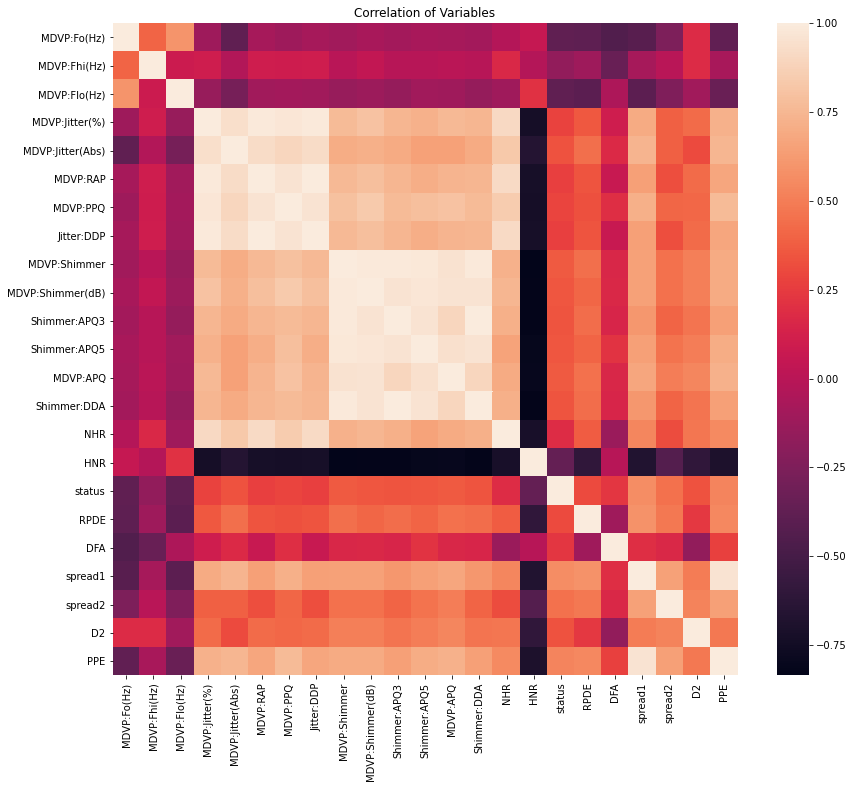

In [5]:
correlation = df.corr()
f, ax = plt.subplots(figsize = (14, 12))
plt.title("Correlation of Variables")
sns.heatmap(correlation)
plt.show()

As we can see from the next two lists (and from the heatmap), a few columns are highly correlated to MDVP:Shimmer and MDVP:Jitter

In [6]:
correlation["MDVP:Shimmer"].sort_values(ascending = False)

MDVP:Shimmer        1.000000
Shimmer:DDA         0.987626
Shimmer:APQ3        0.987625
MDVP:Shimmer(dB)    0.987258
Shimmer:APQ5        0.982835
MDVP:APQ            0.950083
MDVP:PPQ            0.797826
MDVP:Jitter(%)      0.769063
MDVP:RAP            0.759581
Jitter:DDP          0.759555
NHR                 0.722194
MDVP:Jitter(Abs)    0.703322
PPE                 0.693771
spread1             0.654734
D2                  0.507088
spread2             0.452025
RPDE                0.447424
status              0.367430
DFA                 0.159954
MDVP:Fhi(Hz)        0.002281
MDVP:Fo(Hz)        -0.098374
MDVP:Flo(Hz)       -0.144543
HNR                -0.835271
Name: MDVP:Shimmer, dtype: float64

In [7]:
correlation['MDVP:Jitter(%)'].sort_values(ascending = False)

MDVP:Jitter(%)      1.000000
Jitter:DDP          0.990276
MDVP:RAP            0.990276
MDVP:PPQ            0.974256
MDVP:Jitter(Abs)    0.935714
NHR                 0.906959
MDVP:Shimmer(dB)    0.804289
MDVP:Shimmer        0.769063
MDVP:APQ            0.758255
Shimmer:DDA         0.746635
Shimmer:APQ3        0.746625
Shimmer:APQ5        0.725561
PPE                 0.721543
spread1             0.693577
D2                  0.433434
spread2             0.385123
RPDE                0.360673
status              0.278220
MDVP:Fhi(Hz)        0.102086
DFA                 0.098572
MDVP:Fo(Hz)        -0.118003
MDVP:Flo(Hz)       -0.139919
HNR                -0.728165
Name: MDVP:Jitter(%), dtype: float64

Based on these informaiton, we'll drop some columns to prevent overfitting.

In [8]:
Parkinsons_features = df.drop(['name','status', 'Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', "Shimmer:APQ5", 'MDVP:APQ', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:PPQ'], inplace = False, axis = 1)
Parkinsons_labels = df['status']

Next, we are going to scale all values between 0 and 1, so that no column will result more 'important' than others.

In [9]:
scaler = MinMaxScaler((0,1))
X = scaler.fit_transform(Parkinsons_features)
y = Parkinsons_labels

We can now split our dataset. We are using 80% of the data for training and we will try to predict the outcome of the remaining 20%. 

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size  = 0.2, random_state = 1)

We will use XGBoost, as it is known to outperform other models quite often.

In [11]:
model = XGBClassifier() #imported the necessary library in the beginning
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
predictions = model.predict(X_test)
print(predictions)
print(accuracy_score(y_test, predictions)*100)

[1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0
 1 0]
97.43589743589743


By comparing our predictions with the initial dataset, we notice that the XGBoost model was able to predict if the patients had Parkinson's disease with about 97.44% accuracy. We have achieved our goal: we know now that it is possible to detect Parkinson's disease from voice measurements.